<center><font size=18><strong> Metrics</strong></font></center>
<br><br>
This notebook wraps up the metrics used during the training of the models and the evaluation metric for the kaggle competition. It is intended to be used for evaluating the results on the test split.

## Imports

In [80]:
import os 
import pickle

from tqdm.notebook import tqdm
from IPython.display import HTML

In [13]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

#import seqeval.metrics #not used

from transformers import AutoTokenizer

## Evaluation metric

Create a metric to evaluate model performance according to the Kaggle
competition rules.

- For each sample, all ground truths and predictions for a given class are 
    compared.
- If the overlap between the ground truth and prediction is >= 0.5, 
  and the overlap between the prediction and the ground truth >= 0.5, 
  the prediction is a match and considered a true positive. If multiple 
  matches exist, the match with the highest pair of overlaps is taken.
- Any unmatched ground truths are false negatives and any unmatched 
  predictions are false positives.
    

### Get the data
Only for testing purposes

In [62]:
#get the data
df_essays = pd.read_csv('../../raw_data/preprocessed_v3.csv',converters={'predictionstring':eval,
                                                                     'label':eval})
with open('../../raw_data/preds_on_testsplit.pickle','rb') as file:
    y_pred = pickle.load(file)
    
with open('../../raw_data/dataset_v3.pickle','rb') as file:
    dataset = pickle.load(file)


In [63]:
#Max len of essay 
SEQ_LEN = 1024 ## THIS SHOULD NOT BE CHANGED without appropriate changes in the preprocessing 

#Train, val, test split proportion
VAL_SPLIT = 0.8
TEST_SPLIT = 0.9

LEN=len(dataset['labels'])

idx_val=int(LEN*VAL_SPLIT)
idx_test=int(LEN*TEST_SPLIT)

idx_train=list(range(0,idx_val))
idx_val=list(range(idx_val,idx_test))
idx_test=list(range(idx_test,LEN))

assert(len(idx_test)+len(idx_train)+len(idx_val)==LEN)

In [64]:
#creating X_test, y_test, ps_test

X_test = {
    'input_ids' : dataset['inputs']['input_ids'][idx_test],
    'attention_mask' : dataset['inputs']['attention_mask'][idx_test]
}

y_test = dataset['labels'][idx_test]
ps_test = dataset['predictionstrings'][idx_test]

In [65]:
#Labels mapping

labels_mapping = {'B-Lead' : 0,
                  'B-Position' : 1,
                  'B-Evidence' : 2,
                  'B-Claim' : 3,
                  'B-Concluding_Statement' : 4,
                  'B-Counterclaim' : 5,
                  'B-Rebuttal' : 6,
                  'I-Lead' : 7,
                  'I-Position' : 8,
                  'I-Evidence' : 9,
                  'I-Claim' : 10,
                  'I-Concluding_Statement' : 11,
                  'I-Counterclaim' : 12,
                  'I-Rebuttal': 13,
                 'O':14,
                 'PAD':15}

reversed_mapping = {v:(k[2:] if v<14 else k) for k,v in labels_mapping.items()}

### Creating predictions df

In [66]:
def get_preds(y_pred,ps):
    """
    Generate readable predictions from the output of the model.

    Args:
        y_pred (ndarray): output of the model
        ps (ndarray): predictionstring referring to the token predicted

    Returns:
        DataFrame : DataFrame with class and predictionstrings
    """


    labels = []
    predictionstrings = []
    counts = []
    
    counter=dict()
    
    for tok,pos in zip(y_pred,ps):
        
        if tok <= 13:
            lab = reversed_mapping[tok]
            labels.append(lab)
            predictionstrings.append(pos)
            if len(labels)<2:
                counts.append(str(1))
                counter.setdefault(lab,1)
                continue
            if lab == labels[-2]:
                counts.append(str(counter[lab]))
            else: 
                try:
                    counter[lab]+=1
                except KeyError:
                    counter.setdefault(lab,1)
                counts.append(str(counter[lab]))
    
    preds = pd.DataFrame([labels,counts,predictionstrings],index=['class','count','predictionstring']).T
    preds['class'] += ' ' + preds['count'].astype(str)
    preds = preds.groupby('class',sort=False).agg({'predictionstring':list}).reset_index()
    preds['class']=preds['class'].apply(lambda txt : txt.split()[0])
    preds['predictionstring']=preds['predictionstring'].apply(lambda l_ : [str(l) for l in l_])
    preds['predictionstring']=preds['predictionstring'].apply(lambda l_ : ' '.join(l_))
    
    return preds

In [119]:
## Working essay per essay, building pred_df

preds = np.argmax(y_pred,axis=-1)
pred_df=pd.DataFrame()
for i,idx in tqdm(enumerate(idx_test),total=len(idx_test)): ## CHANGE idx_test
    
    pred_ = get_preds(preds[i],ps_test[i])
    
    pred_['id']=df_essays.iloc[idx]['id']
    
    pred_df = pred_df.append(pred_)

  0%|          | 0/1560 [00:00<?, ?it/s]

In [120]:
# Working essay per essay, building true_df

## NB : this does not yield exactly the same result as if 
## we processed train.csv. 
## TODO : First glance shows delta to be negligible. Yet to further investigate.

true = np.argmax(y_test,axis=-1)
true_df=pd.DataFrame()
for i,idx in tqdm(enumerate(idx_test),total=len(idx_test)): ## CHANGE idx_test
    
    true_ = get_preds(true[i],ps_test[i])
    
    true_['id']=df_essays.iloc[idx]['id']
    
    true_df = true_df.append(true_)

  0%|          | 0/1560 [00:00<?, ?it/s]

### Scoring functions

In [121]:
def scoring(predictionstring_true,predictionstring_pred):
    """
    Identify each prediction to be a True Positive, a False Positive or a False 
    Negative according to the competition rules : 
    - For each sample, all ground truths and predictions for a given class are 
    compared.
    - If the overlap between the ground truth and prediction is >= 0.5, 
    and the overlap between the prediction and the ground truth >= 0.5, 
    the prediction is a match and considered a true positive. If multiple 
    matches exist, the match with the highest pair of overlaps is taken.
    - Any unmatched ground truths are false negatives and any unmatched 
    predictions are false positives.
    
    predictionstring_true and predictionstring_pred are a possible match from an
    outer join of all predictions.

    Args:
        predictionstring_true (str): predictionstring of a true discourse
        predictionstring_pred (str): predictionstring of a predicted discourse

    Returns:
        str: TP, FP, or FP 
    """
    
    if predictionstring_true is np.nan :
        return 'FP'
    
    elif predictionstring_pred is np.nan :
        return 'FN'
    
    else:
        
        ps_true = set(predictionstring_true.split(' '))
        ps_pred = set(predictionstring_pred.split(' '))

        inter = ps_pred.intersection(ps_true)
        overlap_1 = len(inter)/len(ps_true)
        overlap_2 = len(inter)/len(ps_pred)

        if overlap_1 >= .5 and overlap_2 >= .5:
            return 'TP'
        else:
            return 'FP'

## vectorize the funct
scoring_vect = np.vectorize(scoring)

In [122]:
def f1_score(fp,fn,tp):
    return tp/(tp+.5*(fp+fn))*100

In [123]:
def scores_df(merged_df):
    """
    Computes f1-score summary.

    Args:
        merged_df (DataFrame): DF with all correspondances of ground truth and 
        predictions.

    Returns:
        df, plot: Returns a dataframe summarizing f1-score per class and a
        barplot showing f1 levels in comparison to the Macro f1-score
    """
    
    merged_df['FP'] = np.where(merged_df['score']=='FP',1,0)
    merged_df['FN'] = np.where(merged_df['score']=='FN',1,0)
    merged_df['TP'] = np.where(merged_df['score']=='TP',1,0)

    merged_df['key'] = merged_df['id']+merged_df['class']+merged_df['predictionstring_pred']+\
                        merged_df['predictionstring_true']
    
    idx_potential_duplicates = merged_df[(merged_df['key'].duplicated()) & (merged_df['TP']==1)].index
    
    merged_df.drop(idx_potential_duplicates,inplace=True,axis=0)
    
    merged_df.drop('key',axis=1,inplace=True)
    
    score_df = merged_df.groupby('class').agg({'TP':sum,'FP':sum,'FN':sum})
    score_df['F1'] = f1_score(score_df.FP,score_df.FN,score_df.TP)
    
    #Create a total row
    score_df.loc['Total']=score_df.mean()

    ## weighted average
    score_df['Support'] = true_df.groupby('class').count()['id']
    score_df['F1_Weighted']=score_df['F1']*(score_df['Support']/score_df['Support'].sum())
    score_df.loc['Total','Support']=score_df.Support.sum()
    score_df.loc['Total','F1_Weighted']=score_df.F1_Weighted.sum()

    # impute correct values for the Total row for TP FN FP 
    score_df.loc['Total','FP'] = score_df.loc[:'Rebuttal','FP'].sum()
    score_df.loc['Total','FN'] = score_df.loc[:'Rebuttal','FN'].sum()
    score_df.loc['Total','TP'] = score_df.loc[:'Rebuttal','TP'].sum()    
    
    #Print aggregated scores
    print(f"F1 Macro Score = {score_df.loc['Total','F1']:.2f}%")
    print(f"F1 Micro Score = {f1_score(score_df.loc['Total','FP'],score_df.loc['Total','FN'],score_df.loc['Total','TP']):.2f}%")
    print(f"F1 Weighted Score = {score_df.loc['Total','F1_Weighted']:.2f}%")
    
    ## Creating figure
    sns.barplot(y=score_df.reset_index().loc[:6,'F1'],x=score_df.index[:-1],palette='Set2')
    plt.xticks(rotation=90)
    locs,_=plt.xticks()
    plt.plot([locs[0]-.5,locs[-1]+.5],[score_df.loc['Total','F1'],score_df.loc['Total','F1']],c='r');
    plt.title('Macro F1',size= 16);

    ## FORMATING
    score_df[['TP','FN','FP','Support']] = score_df[['TP','FN','FP','Support']].applymap('{:.0f}'.format)
    score_df[['F1','F1_Weighted']] = score_df[['F1','F1_Weighted']].applymap('{:.2f}%'.format)
    
    
    return score_df

### Building F1 report

In [124]:
#Merge true_df and pred_df to get all possible matches
merged_df = pred_df.merge(true_df,how = 'outer',on=['id','class'],suffixes=('_pred','_true'))
merged_df['score'] = scoring_vect(merged_df.predictionstring_true,
                                  merged_df.predictionstring_pred) # apply scoring func to determine for each
                                                                    # pred if it FP,FN,TP
merged_df.head()

,class,predictionstring_pred,id,predictionstring_true,score
0,Lead,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,E6870101D8EE,NaN,FP
1,Lead,65 66 67 68 69 70 71 72 73 74 75 76 77 78,E6870101D8EE,NaN,FP
2,Lead,83 84,E6870101D8EE,NaN,FP
3,Evidence,31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 4...,E6870101D8EE,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,FP
4,Evidence,31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 4...,E6870101D8EE,110 111 112 113 114 115 116 117 118 119 120 12...,FP


F1 Macro Score = 44.92%
F1 Micro Score = 39.31%
F1 Weighted Score = 42.86%


,TP,FP,FN,F1,Support,F1_Weighted
class,,,,,,
Claim,1570,7897,49,28.32%,3412,8.06%
Concluding_Statement,1106,605,27,77.78%,1346,8.73%
Counterclaim,141,573,202,26.68%,542,1.21%
Evidence,2400,9860,0,32.74%,3792,10.35%
Lead,774,618,50,69.86%,963,5.61%
Position,955,909,68,66.16%,1535,8.47%
Rebuttal,57,571,199,12.90%,402,0.43%
Total,7003,21033,595,44.92%,11992,42.86%


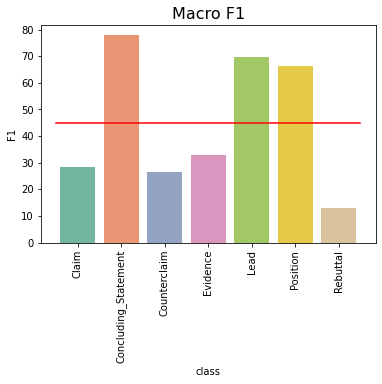

In [125]:
f1_report = scores_df(merged_df)
f1_report

## Confusion matrix

In [126]:
from sklearn.metrics import confusion_matrix

In [127]:
def show_confusion_matrix(y_true,y_pred):
    """
    Plots a confusion matrix.

    Args:
        y_true (np.array): targets of shape (None, 1024)
        y_pred (np.array): targets predicted of shape (None, 1024)
    """

    reversed_mapping = {
                        0: 'Lead',
                        1: 'Position',
                        2: 'Evidence',
                        3: 'Claim',
                        4: 'Concluding_Statement',
                        5: 'Counterclaim',
                        6: 'Rebuttal',
                        7: 'Lead',
                        8: 'Position',
                        9: 'Evidence',
                        10: 'Claim',
                        11: 'Concluding_Statement',
                        12: 'Counterclaim',
                        13: 'Rebuttal',
                        14: 'O',
                        15: 'PAD'}
    
    y_true_flat = [reversed_mapping[y] for y in y_true.flatten()]
    y_pred_flat = [reversed_mapping[y] for y in y_pred.flatten()]
    
    LABELS = ['Lead','Position','Claim','Counterclaim','Rebuttal','Evidence','Concluding_Statement','O','PAD']

    cfn = confusion_matrix(y_true_flat,y_pred_flat,labels=LABELS)
    
    fig,ax = plt.subplots(1,1,figsize=(10,10))
    plt.title('Confusion Matrix',size=18,pad=20)
    sns.heatmap(cfn/np.sum(cfn,axis=0)*100,cmap='Blues',annot = True,fmt='.2f',annot_kws={'size':10},ax=ax);
    plt.xticks(np.arange(len(LABELS))+.5,LABELS,rotation = 90,size=12);
    plt.yticks(np.arange(len(LABELS))+.5,LABELS,rotation = 0,size=12);
    plt.xlabel('PREDICTED',size=16);
    plt.ylabel('ACTUAL',size=16);
    for t in ax.texts: t.set_text(t.get_text() + " %")
    
    plt.show()

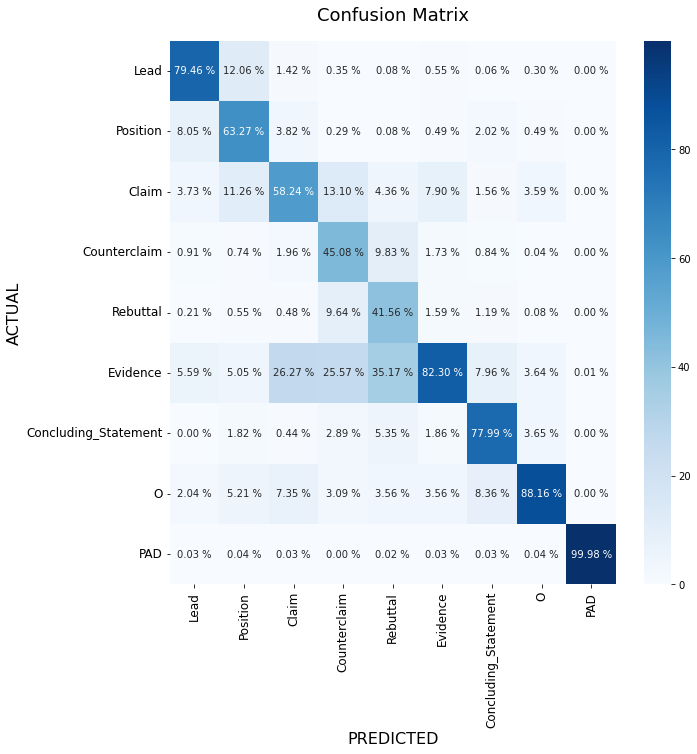

In [128]:
show_confusion_matrix(true,preds)

In [129]:
pred_df

,class,predictionstring,id
0,Lead,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,E6870101D8EE
1,Evidence,31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 4...,E6870101D8EE
2,Lead,65 66 67 68 69 70 71 72 73 74 75 76 77 78,E6870101D8EE
3,Claim,79 80 81 82,E6870101D8EE
4,Lead,83 84,E6870101D8EE
...,...,...,...
5,Evidence,122 123 124 125 126 127 128 129 130 131 132 13...,FFFD0AF13501
6,Concluding_Statement,195 196 197 198 199 200 201 202 203 204 205 20...,FFFD0AF13501
0,Lead,0 1 2 3 4 5 6,FFFF80B8CC2F
1,Evidence,7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 2...,FFFF80B8CC2F


## Visualize

### Match predictionstring and text

In [130]:
def get_essay(id_,mode='train'):
    """Function to get the full text of an essay from the .txt file.

    Args:
        id_ (str): id of the essay
        mode (str, optional): determines whether to access *train* or *test* texts. \
        Defaults to 'train'.

    Returns:
        str: Returns the full text of the id
    """
    with open(os.path.join('../../raw_data',mode,f'{id_}.txt'),'r') as file:
        txt = file.read()
    return txt.strip()

In [131]:
#retrie the full text of the essay
pred_df['text']=pred_df['id'].apply(get_essay)
true_df['text']=true_df['id'].apply(get_essay)

In [132]:
#creating a function that will slice the full essay text from predictionstring

def slicer(text,idx_first_word,idx_last_word):
    text = text.split()
    if idx_first_word==0:
        return ' '.join(text[:idx_last_word+1])
    return ' '.join(text[idx_first_word:idx_last_word+1])
    
slicer_vect=np.vectorize(slicer) #vectorize

In [133]:
## utilities columns to get first and last word index for each discourse
pred_df['first_word'] = pred_df['predictionstring'].apply(lambda txt : txt.split()[0]).astype(int)
pred_df['last_word'] = pred_df['predictionstring'].apply(lambda txt : txt.split()[-1]).astype(int)
true_df['first_word'] = true_df['predictionstring'].apply(lambda txt : txt.split()[0]).astype(int)
true_df['last_word'] = true_df['predictionstring'].apply(lambda txt : txt.split()[-1]).astype(int)


In [134]:
pred_df['discourse_text']=slicer_vect(pred_df['text'],pred_df['first_word'],pred_df['last_word'])
true_df['discourse_text']=slicer_vect(true_df['text'],true_df['first_word'],true_df['last_word'])

### Build HTLM dataframe for visualization purposes

In [135]:
#keep only columns of interest
pred_df.drop(['predictionstring','text','first_word','last_word'],axis=1,inplace=True)
true_df.drop(['predictionstring','text','first_word','last_word'],axis=1,inplace=True)

In [136]:
def render_html(df):
    return "<{0} style='padding: 2px'>{1} <strong> [{0}] </strong></{0}>".format(df['class'],df['discourse_text'])

In [137]:
#apply html function
true_df['html'] = true_df.apply(render_html,axis=1)
pred_df['html'] = pred_df.apply(render_html,axis=1)

In [138]:
#group by essay 
true_df = true_df.groupby('id').agg({'html':' '.join,}).reset_index()
pred_df = pred_df.groupby('id').agg({'html':' '.join,}).reset_index()

### Visualize random essays across the test split

In [139]:
def css():
    styles = open("./styles/custom.css", "r").read()
    return HTML('<style>'+styles+'</style>')
css()

In [140]:
def comparison_text(prediction, ground_truth):
    html = f"""
    <div class="content">
     <span style="font-size:16px">Legend --></span>
      <lead>Lead</lead>
      <Position>Position</Position>
      <Claim>Claim</Claim>
      <Counterclaim>Counterclaim</Counterclaim>
      <Rebuttal>Rebuttal</Rebuttal>
      <Evidence>Evidence</Evidence>
      <Concluding_Statement>Concluding_Statement</Concluding_Statement>
    </div>

    <div class="row">
      <div class="column">
        <h2 class="title">Prediction</h2>
        <p style="text-align:justify">{prediction}</p>
      </div>
      <div class="column">
        <h2 class="title">Ground Truth</h2>
        <p style="text-align:justify">{ground_truth}</p>
      </div>
    </div>
    
    """
    
    return HTML(html)

In [141]:
for i in range(10):
    display(comparison_text(pred_df.loc[i,'html'],true_df.loc[i,'html']))